# Heatmap Figures
## Fig. 4 in main text
## Fig. S4 in SI




## Overview

This notebook generates publication-ready heatmap figures for visualizing evolutionary
dynamics on multilayer networks. The figures display parameter regimes where different
strategies are favored by selection.

### Figure Types

1. **4×3 Composite Figure**: Four example network topologies, each with two update rule
   variants (dB-dB and dB-Bd)
2. **Single Row Figure**: Focused view on a single network topology

### Color Coding

The heatmaps use a scientific diverging color palette to indicate selection outcomes:

| Color | Meaning |
|-------|--------|
| 🟢  | Both cooperators AND mutants favored |
| 🟢  | Cooperators favored, mutants NOT favored |
| 🟠  | Mutants favored, cooperators NOT favored |
| 🔴  | Neither cooperators nor mutants favored |

### Parameters

- **b/c**: Benefit-to-cost ratio in the donation game (x-axis)
- **r**: Relative fitness of mutant type in constant selection layer (y-axis)
- **Vertical dashed line**: Critical b/c threshold from theory

## Table of Contents

1. [Setup and Imports](#setup)
2. [Helper Functions](#helpers)
3. [Color Palette Configuration](#colors)
4. [Heatmap Drawing Functions](#heatmap-funcs)
5. [4×3 Composite Figure](#composite-figure)
6. [Single Row Figure](#single-row-figure)

---

<a id='setup'></a>
## 1. Setup and Imports

In [1]:
"""
Required Dependencies
---------------------
- numpy: Numerical array operations
- matplotlib: Plotting and visualization
- os: File path operations
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from typing import Tuple, Optional, List, Dict, Any

print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

NumPy version: 1.26.4
Matplotlib version: 3.10.3


---

<a id='helpers'></a>
## 2. Helper Functions

Utility functions for data loading, image processing, and axis formatting.

In [2]:
# =============================================================================
# DATA LOADING
# =============================================================================

def load_npz(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load heatmap data from a NumPy .npz file.
    
    The expected file format contains two arrays:
    - 'x_values': Selection coefficient for cooperators (rho_C - 1/N)
    - 'y_values': Selection coefficient for mutants (rho_M - 1/N)
    
    Parameters
    ----------
    path : str
        Path to the .npz file.
    
    Returns
    -------
    x_values : ndarray
        2D array of cooperator selection coefficients, shape (n_r, n_b).
    y_values : ndarray
        2D array of mutant selection coefficients, shape (n_r, n_b).
    
    Examples
    --------
    >>> x, y = load_npz("heatmap1_dB_dB.npz")
    >>> print(f"Data shape: {x.shape}")
    """
    data = np.load(path)
    return data["x_values"], data["y_values"]


def infer_axis_values(
    data_shape: Tuple[int, int],
    b_range: Tuple[float, float] = (-20.0, 10.0),
    r_range: Tuple[float, float] = (0.0, 20.0)
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Infer axis values from data array dimensions.
    
    Creates linearly spaced axis values based on the data shape
    and the specified parameter ranges.
    
    Parameters
    ----------
    data_shape : tuple of int
        Shape of the data array (n_r, n_b).
    b_range : tuple of float, default=(-20.0, 10.0)
        Range of benefit-to-cost ratio values.
    r_range : tuple of float, default=(0.0, 20.0)
        Range of relative fitness values.
    
    Returns
    -------
    b_vals : ndarray
        1D array of b/c values.
    r_vals : ndarray
        1D array of r values.
    """
    n_r, n_b = data_shape
    b_vals = np.linspace(b_range[0], b_range[1], n_b)
    r_vals = np.linspace(r_range[0], r_range[1], n_r)
    return b_vals, r_vals


# =============================================================================
# COLOR CLASSIFICATION
# =============================================================================

def compute_colors_mat(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Classify each parameter point into one of four selection regimes.
    
    Based on the selection coefficients for cooperators (x) and mutants (y),
    assigns each point to a category:
    
    - Category 1: Both favored (x > 0 and y > 0)
    - Category 2: Only cooperators favored (x > 0 and y ≤ 0)
    - Category 3: Only mutants favored (x ≤ 0 and y > 0)
    - Category 4: Neither favored (x ≤ 0 and y ≤ 0)
    
    Parameters
    ----------
    x : ndarray
        Selection coefficient for cooperators (rho_C - 1/N).
        Positive values indicate cooperators are favored.
    y : ndarray
        Selection coefficient for mutants (rho_M - 1/N).
        Positive values indicate mutants are favored.
    
    Returns
    -------
    Z : ndarray
        Integer array with values 1-4 indicating the selection regime.
    
    Notes
    -----
    A small threshold (1e-10) is used for cooperator classification to
    handle numerical precision issues near the neutral boundary.
    """
    Z = np.full_like(x, 4, dtype=int)  # Default: neither favored
    
    # Apply classification rules
    Z[(x > 1e-10) & (y > 0)] = 1    # Both favored (bright green)
    Z[(x > 0) & (y <= 0)] = 2       # Cooperators only (light green)
    Z[(x <= 1e-10) & (y > 0)] = 3   # Mutants only (light coral)
    Z[~((x > 0) | (y > 0))] = 4     # Neither favored (deep red)
    
    return Z


# =============================================================================
# IMAGE PROCESSING
# =============================================================================

def center_crop(img: np.ndarray, zoom: float = 1.0) -> np.ndarray:
    """
    Crop an image to its center with optional zoom.
    
    Parameters
    ----------
    img : ndarray
        Input image array with shape (height, width, channels).
    zoom : float, default=1.0
        Zoom factor. Values > 1 crop more (zoom in), < 1 would zoom out.
        A value of 1.0 applies a small 5% border crop.
    
    Returns
    -------
    cropped : ndarray
        Center-cropped image.
    """
    h, w = img.shape[:2]
    
    if zoom == 1.0:
        # Default: remove 5% border on each side
        border = 0.05
        new_w = int(w * (1 - 2 * border))
        new_h = int(h * (1 - 2 * border))
    else:
        # Custom zoom: larger zoom = smaller crop = more zoomed in
        new_w = int(w / zoom)
        new_h = int(h / zoom)
    
    # Calculate crop coordinates (centered)
    x0 = (w - new_w) // 2
    y0 = (h - new_h) // 2
    
    return img[y0:y0 + new_h, x0:x0 + new_w]


# =============================================================================
# AXIS FORMATTING
# =============================================================================

def edges_from_centers(vals: np.ndarray) -> np.ndarray:
    """
    Compute cell edges from cell center values for pcolormesh.
    
    Matplotlib's pcolormesh requires edge coordinates, not centers.
    This function converts N center values to N+1 edge values.
    
    Parameters
    ----------
    vals : ndarray
        1D array of cell center values (length N).
    
    Returns
    -------
    edges : ndarray
        1D array of cell edge values (length N+1).
    
    Examples
    --------
    >>> centers = np.array([1, 2, 3, 4])
    >>> edges_from_centers(centers)
    array([0.5, 1.5, 2.5, 3.5, 4.5])
    """
    vals = np.asarray(vals)
    step = vals[1] - vals[0] if len(vals) > 1 else 1.0
    
    return np.concatenate([
        [vals[0] - step / 2],              # First edge
        (vals[:-1] + vals[1:]) / 2,        # Middle edges (midpoints)
        [vals[-1] + step / 2]              # Last edge
    ])


def set_integer_yticks(
    ax: plt.Axes,
    rmin: float,
    rmax: float,
    nticks: int = 4,
    custom_ticks: Optional[List[int]] = None
) -> None:
    """
    Set integer y-axis tick marks with optional custom values.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to modify.
    rmin, rmax : float
        Y-axis range limits.
    nticks : int, default=4
        Number of tick marks (used if custom_ticks not provided).
    custom_ticks : list of int, optional
        Explicit tick values to use instead of auto-generated ones.
    """
    if custom_ticks is not None:
        ax.set_yticks(custom_ticks)
    else:
        raw = np.linspace(rmin, rmax, nticks)
        ticks = np.unique(np.round(raw).astype(int))
        ax.set_yticks(ticks)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))


def set_four_xticks(ax: plt.Axes, bmin: float, bmax: float) -> None:
    """
    Set exactly four evenly-spaced x-axis tick marks.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to modify.
    bmin, bmax : float
        X-axis range limits.
    """
    ax.set_xticks(np.linspace(bmin, bmax, 4))


def set_custom_xticks(ax: plt.Axes, ticks: List[float]) -> None:
    """
    Set custom x-axis tick values.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to modify.
    ticks : list of float
        Explicit tick values.
    """
    ax.set_xticks(ticks)

---

<a id='colors'></a>
## 3. Color Palette Configuration

Define the scientific color scheme for the heatmaps. The palette uses a
green-red diverging scheme that is colorblind-friendly and publication-ready.

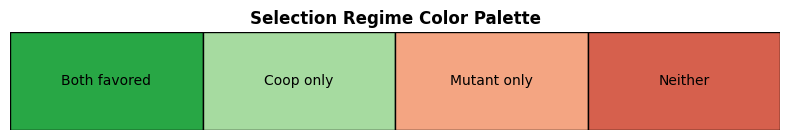

In [3]:
# =============================================================================
# COLOR PALETTE DEFINITION
# =============================================================================

# Scientific diverging palette (green-red)
# Colors chosen for accessibility and visual clarity

COL_BOTH_FAV = "#28A745"      # Deep green: both cooperators AND mutants favored
COL_COOP_ONLY = "#A6DBA0"     # Light green: cooperators favored, mutants NOT
COL_MUTANT_ONLY = "#F4A582"   # Light coral: mutants favored, cooperators NOT
COL_NEITHER = "#D6604D"       # Deep red: neither favored

# Build the discrete colormap
# Maps integer values 1-4 to the four colors
CMAP = ListedColormap([
    COL_BOTH_FAV,      # Category 1: both favored
    COL_COOP_ONLY,     # Category 2: cooperators only
    COL_MUTANT_ONLY,   # Category 3: mutants only
    COL_NEITHER        # Category 4: neither favored
])

# Boundary norm maps data values to colormap indices
# Values 0.5-1.5 → color 0, 1.5-2.5 → color 1, etc.
NORM = BoundaryNorm([0.5, 1.5, 2.5, 3.5, 4.5], CMAP.N)


def create_legend_handles() -> List[Patch]:
    """
    Create legend patch handles for the four selection regimes.
    
    Returns
    -------
    handles : list of Patch
        Matplotlib patch objects for legend creation.
    """
    return [
        Patch(
            facecolor=COL_BOTH_FAV,
            edgecolor="#2C3E50",
            linewidth=2,
            label='Cooperators and mutants favored'
        ),
        Patch(
            facecolor=COL_COOP_ONLY,
            edgecolor="#2C3E50",
            linewidth=2,
            label='Cooperators but not mutants favored'
        ),
        Patch(
            facecolor=COL_MUTANT_ONLY,
            edgecolor="#2C3E50",
            linewidth=2,
            label='Mutants but not cooperators favored'
        ),
        Patch(
            facecolor=COL_NEITHER,
            edgecolor="#2C3E50",
            linewidth=2,
            label='Neither favored'
        ),
    ]


# Display the color palette
fig, ax = plt.subplots(figsize=(8, 1.5))
for i, (color, label) in enumerate([
    (COL_BOTH_FAV, "Both favored"),
    (COL_COOP_ONLY, "Coop only"),
    (COL_MUTANT_ONLY, "Mutant only"),
    (COL_NEITHER, "Neither")
]):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black'))
    ax.text(i + 0.5, 0.5, label, ha='center', va='center', fontsize=10)

ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Selection Regime Color Palette', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

<a id='heatmap-funcs'></a>
## 4. Heatmap Drawing Functions

Core visualization functions for creating heatmap panels.

In [4]:
def apply_axis_styling(ax: plt.Axes) -> None:
    """
    Apply consistent publication-quality styling to an axes object.
    
    Sets border widths, colors, tick parameters, and removes grid lines
    for a clean, professional appearance.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to style.
    """
    ax.grid(False)
    
    # Refined border styling
    for spine in ax.spines.values():
        spine.set_linewidth(1.8)
        spine.set_edgecolor('#34495E')
    
    # Tick styling
    ax.tick_params(width=1.5, length=6, colors='#2C3E50')


def draw_heatmap(
    ax: plt.Axes,
    npz_path: str,
    b_values: np.ndarray,
    r_values: np.ndarray,
    vline_value: Optional[float] = None,
    xlabel: str = "",
    force_four_xticks: bool = False,
    square: bool = True,
    custom_yticks: Optional[List[int]] = None,
    custom_xticks: Optional[List[float]] = None,
    ymax_override: Optional[float] = None,
    xlim_override: Optional[Tuple[float, float]] = None
) -> None:
    """
    Draw a selection regime heatmap on the given axes.
    
    Loads data from an .npz file, classifies each point into a selection
    regime, and renders as a colored heatmap.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw on.
    npz_path : str
        Path to the .npz data file.
    b_values : ndarray
        1D array of benefit-to-cost ratio values (x-axis).
    r_values : ndarray
        1D array of relative fitness values (y-axis).
    vline_value : float, optional
        X-coordinate for a vertical reference line (e.g., critical threshold).
    xlabel : str, default=""
        Label for the x-axis.
    force_four_xticks : bool, default=False
        If True, force exactly 4 x-axis tick marks.
    square : bool, default=True
        If True, maintain square aspect ratio.
    custom_yticks : list of int, optional
        Custom y-axis tick values.
    custom_xticks : list of float, optional
        Custom x-axis tick values.
    ymax_override : float, optional
        Override the maximum y-axis value.
    xlim_override : tuple of float, optional
        Override the x-axis limits as (xmin, xmax).
    
    Raises
    ------
    ValueError
        If the data shape doesn't match the provided axis values.
    """
    # Load and validate data
    x_vals, y_vals = load_npz(npz_path)
    
    expected_shape = (len(r_values), len(b_values))
    if x_vals.shape != expected_shape:
        raise ValueError(
            f"Axis mismatch for {npz_path}: "
            f"data shape {x_vals.shape} vs expected {expected_shape}"
        )
    
    # Classify points into selection regimes
    Z = compute_colors_mat(x_vals, y_vals)
    
    # Compute cell edges for pcolormesh
    bx = edges_from_centers(b_values)
    ry = edges_from_centers(r_values)
    
    # Draw heatmap
    ax.set_facecolor("#F8F8F8")
    ax.pcolormesh(
        bx, ry, Z,
        cmap=CMAP,
        norm=NORM,
        shading="auto",
        edgecolors='none',
        linewidth=0,
        rasterized=True  # Reduces file size for vector output
    )
    
    # Axis labels
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=22)
    ax.set_ylabel(r"$r$", fontweight='bold', fontsize=22)
    
    # Optional vertical reference line
    if vline_value is not None and np.isfinite(vline_value):
        ax.axvline(
            vline_value,
            linewidth=2.8,
            color="#2C3E50",
            linestyle=':',
            alpha=0.85,
            zorder=10
        )
    
    # Set axis limits
    rmin = float(r_values[0])
    rmax = float(r_values[-1]) if ymax_override is None else ymax_override
    ax.set_ylim(rmin, rmax)
    
    if xlim_override is not None:
        ax.set_xlim(xlim_override[0], xlim_override[1])
    
    # Configure tick marks
    set_integer_yticks(ax, rmin, rmax, nticks=4, custom_ticks=custom_yticks)
    
    if custom_xticks is not None:
        set_custom_xticks(ax, custom_xticks)
    elif force_four_xticks:
        set_four_xticks(ax, float(b_values[0]), float(b_values[-1]))
    
    # Apply styling
    apply_axis_styling(ax)
    
    if square:
        ax.set_box_aspect(1)


def draw_heatmap_auto(
    ax: plt.Axes,
    npz_path: str,
    vline_value: Optional[float] = None,
    xlabel: str = "",
    b_range: Tuple[float, float] = (-20.0, 10.0),
    r_range: Tuple[float, float] = (0.0, 20.0)
) -> None:
    """
    Draw a heatmap with auto-detected axis values.
    
    Simplified version that infers axis values from the data shape.
    Useful when exact axis values aren't critical.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw on.
    npz_path : str
        Path to the .npz data file.
    vline_value : float, optional
        X-coordinate for vertical reference line.
    xlabel : str, default=""
        Label for the x-axis.
    b_range : tuple of float, default=(-20.0, 10.0)
        Range of b/c values for axis generation.
    r_range : tuple of float, default=(0.0, 20.0)
        Range of r values for axis generation.
    """
    # Load data and infer axes
    x_vals, y_vals = load_npz(npz_path)
    b_values, r_values = infer_axis_values(x_vals.shape, b_range, r_range)
    
    # Classify and compute edges
    Z = compute_colors_mat(x_vals, y_vals)
    bx = edges_from_centers(b_values)
    ry = edges_from_centers(r_values)
    
    # Draw heatmap
    ax.set_facecolor("#F8F8F8")
    ax.pcolormesh(
        bx, ry, Z,
        cmap=CMAP,
        norm=NORM,
        shading="auto",
        edgecolors='none',
        linewidth=0,
        rasterized=True
    )
    
    # Labels
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=22)
    ax.set_ylabel(r"$r$", fontweight='bold', fontsize=22)
    
    # Vertical line
    if vline_value is not None and np.isfinite(vline_value):
        ax.axvline(
            vline_value,
            linewidth=2.8,
            color="#2C3E50",
            linestyle=':',
            alpha=0.85,
            zorder=10
        )
    
    # Ticks and styling
    set_integer_yticks(ax, float(r_range[0]), float(r_range[1]), nticks=5)
    set_four_xticks(ax, float(b_values[0]), float(b_values[-1]))
    apply_axis_styling(ax)
    ax.set_box_aspect(1)


def draw_three_band_extrapolated(
    ax: plt.Axes,
    npz_path: str,
    b_values: np.ndarray,
    r_values: np.ndarray,
    xlabel: str = "",
    custom_yticks: Optional[List[int]] = None,
    custom_xticks: Optional[List[float]] = None,
    target_rmax: float = 20.0,
    xlim_override: Optional[Tuple[float, float]] = None
) -> None:
    """
    Draw an extrapolated three-band heatmap for theoretical predictions.
    
    Uses actual data to locate the transition boundaries, then extrapolates
    to create three horizontal bands (red → middle → green) extending
    beyond the original data range.
    
    This is useful for row (d) in composite figures where the pattern
    is known to continue as simple horizontal bands.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw on.
    npz_path : str
        Path to the .npz data file.
    b_values : ndarray
        1D array of b/c values (x-axis).
    r_values : ndarray
        1D array of r values (y-axis) from original data.
    xlabel : str, default=""
        X-axis label.
    custom_yticks : list of int, optional
        Custom y-axis tick values.
    custom_xticks : list of float, optional
        Custom x-axis tick values.
    target_rmax : float, default=20.0
        Maximum r value for the extrapolated plot.
    xlim_override : tuple of float, optional
        Override x-axis limits.
    """
    # Load data and classify
    x_vals, y_vals = load_npz(npz_path)
    Z_data = compute_colors_mat(x_vals, y_vals)
    n_r, _ = Z_data.shape
    
    # ----- Locate band boundaries along r (row index) -----
    
    # Find first row with any green (both favored = 1)
    mask_green = (Z_data == 1)
    if np.any(mask_green):
        i_green_start = np.where(mask_green.any(axis=1))[0].min()
    else:
        i_green_start = n_r  # No green: set beyond last row
    
    # Find last row with any deep red (neither favored = 4)
    mask_red = (Z_data == 4)
    if np.any(mask_red):
        i_red_last = np.where(mask_red.any(axis=1))[0].max()
    else:
        i_red_last = -1  # No red: set before first row
    
    # Determine middle band color (2 or 3) from transition region
    mid_code = 3  # Default to coral/orange
    if i_red_last + 1 < i_green_start:
        mid_slice = Z_data[i_red_last + 1:i_green_start, :]
        if mid_slice.size > 0:
            vals, counts = np.unique(mid_slice, return_counts=True)
            mid_candidates = [v for v in vals if v in (2, 3)]
            if mid_candidates:
                # Pick the most common middle color
                best = max(mid_candidates, key=lambda v: counts[vals == v][0])
                mid_code = best
    
    # ----- Convert row indices to r-values -----
    r0 = float(r_values[0])
    dr = float(r_values[1] - r_values[0]) if len(r_values) > 1 else 0.1
    
    r_green_start = r0 + i_green_start * dr
    r_red_last_val = r0 + max(i_red_last, 0) * dr
    
    # Build extended r-grid up to target_rmax
    r_ext = np.arange(r0, target_rmax + 1e-9, dr)
    nr_ext = len(r_ext)
    
    # Build extended b-grid
    db = float(b_values[1] - b_values[0]) if len(b_values) > 1 else 0.01
    if xlim_override is not None:
        bmin, bmax = float(xlim_override[0]), float(xlim_override[1])
    else:
        bmin, bmax = float(b_values[0]), float(b_values[-1])
    b_ext = np.arange(bmin, bmax + 1e-9, db)
    nb_ext = len(b_ext)
    
    # ----- Construct three-band Z matrix -----
    Z_ext = np.empty((nr_ext, nb_ext), dtype=int)
    for i, r in enumerate(r_ext):
        if i_red_last >= 0 and r <= r_red_last_val + 1e-9:
            Z_ext[i, :] = 4          # Bottom: red band
        elif r < r_green_start - 1e-9:
            Z_ext[i, :] = mid_code   # Middle band
        else:
            Z_ext[i, :] = 1          # Top: green band
    
    # ----- Draw the extrapolated heatmap -----
    bx = edges_from_centers(b_ext)
    ry = edges_from_centers(r_ext)
    
    ax.set_facecolor("#F8F8F8")
    ax.pcolormesh(
        bx, ry, Z_ext,
        cmap=CMAP,
        norm=NORM,
        shading="auto",
        edgecolors="none",
        linewidth=0,
        rasterized=True
    )
    
    # Labels and limits
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=22)
    ax.set_ylabel(r"$r$", fontweight='bold', fontsize=22)
    ax.set_ylim(r0, target_rmax)
    ax.set_xlim(bmin, bmax)
    
    # Ticks
    set_integer_yticks(ax, r0, target_rmax, nticks=4, custom_ticks=custom_yticks)
    if custom_xticks is not None:
        set_custom_xticks(ax, custom_xticks)
    
    # Styling
    apply_axis_styling(ax)
    ax.set_box_aspect(1)

---

<a id='composite-figure'></a>
## 5. Figure 4 of main text

Generate the figure showing four network topologies with
two update rule variants each.

### Layout

| Row | Column 1 | Column 2 | Column 3 |
|-----|----------|----------|----------|
| (a) | Ring network | dB-dB heatmap | dB-Bd heatmap |
| (b) | Heterogeneous | dB-dB heatmap | dB-Bd heatmap |
| (c) | Complete | dB-dB heatmap | dB-Bd heatmap |
| (d) | Bipartite | dB-dB heatmap | dB-Bd heatmap |

In [5]:
# =============================================================================
# AXES CONFIGURATION
# =============================================================================

# Define axis ranges and styling for each heatmap
# Each entry specifies the data file parameters and display options

AXES_CONFIG = {
    # ----- Row (a): Ring/Cycle network -----
    "heatmap1_dB_dB.npz": dict(
        b=np.arange(2.3, 3.0 + 0.001, 0.001),
        r=np.arange(0.0, 3.0 + 0.001, 0.001),
        vline=2.67,  # Critical b/c threshold
        xlabel="",
        custom_yticks=None,
        custom_xticks=None,
        ymax_override=None,
        xlim_override=None
    ),
    "heatmap1_dB_Bd.npz": dict(
        b=np.arange(2.3, 3.0 + 0.001, 0.001),
        r=np.arange(0.0, 3.0 + 0.001, 0.001),
        vline=2.67,
        xlabel="",
        custom_yticks=None,
        custom_xticks=None,
        ymax_override=None,
        xlim_override=None
    ),
    
    # ----- Row (b): Heterogeneous network -----
    "heatmap2_dB_dB.npz": dict(
        b=np.arange(-20.0, 10.0 + 0.01, 0.01),
        r=np.arange(0.0, 35.0 + 0.01, 0.01),
        vline=-15.89,
        xlabel="",
        custom_yticks=[0, 5, 10, 15, 20],
        custom_xticks=None,
        ymax_override=20,
        xlim_override=None
    ),
    "heatmap2_dB_Bd.npz": dict(
        b=np.arange(-20.0, 10.0 + 0.01, 0.01),
        r=np.arange(0.0, 35.0 + 0.01, 0.01),
        vline=-15.89,
        xlabel="",
        custom_yticks=[0, 5, 10, 15, 20],
        custom_xticks=None,
        ymax_override=20,
        xlim_override=None
    ),
    
    # ----- Row (c): Complete graph -----
    "heatmap3_dB_dB.npz": dict(
        b=np.arange(-15.0, 15.0 + 0.1, 0.1),
        r=np.arange(0.0, 15.0 + 0.01, 0.01),
        vline=-9,
        xlabel="",
        custom_yticks=None,
        custom_xticks=[-15, -10, -5, 0, 5, 10, 15],
        ymax_override=None,
        xlim_override=None
    ),
    "heatmap3_dB_Bd.npz": dict(
        b=np.arange(-15.0, 15.0 + 0.1, 0.1),
        r=np.arange(0.0, 15.0 + 0.01, 0.01),
        vline=-9,
        xlabel="",
        custom_yticks=None,
        custom_xticks=[-15, -10, -5, 0, 5, 10, 15],
        ymax_override=None,
        xlim_override=None
    ),
    
    # ----- Row (d): Bipartite network (extrapolated) -----
    "heatmap4_dB_dB.npz": dict(
        b=np.arange(-1.0, 2.0 + 0.01, 0.01),
        r=np.arange(0.0, 18.0 + 0.1, 0.1),
        vline=np.inf,  # No vertical line
        xlabel=r"$b/c$",
        custom_yticks=[0, 5, 10, 15, 20],
        custom_xticks=[-2, -1, 0, 1, 2],
        ymax_override=20,
        xlim_override=(-2, 2)
    ),
    "heatmap4_dB_Bd.npz": dict(
        b=np.arange(-1.0, 2.0 + 0.01, 0.01),
        r=np.arange(0.0, 18.0 + 0.1, 0.1),
        vline=np.inf,
        xlabel=r"$b/c$",
        custom_yticks=[0, 5, 10, 15, 20],
        custom_xticks=[-2, -1, 0, 1, 2],
        ymax_override=20,
        xlim_override=(-2, 2)
    ),
}

# Network diagram image files (one per row)
NETWORK_IMAGES = [
    "ring_layer_network_3d.png",
    "multi_layer_network_hetero.png",
    "complete_multi_layer_network_3d.png",
    "equal_complete_bipartite_multi_layer_network_3d.png",
]

# Heatmap data files
HEATMAP_FILES_DB_DB = [f"heatmap{i}_dB_dB.npz" for i in range(1, 5)]
HEATMAP_FILES_DB_BD = [f"heatmap{i}_dB_Bd.npz" for i in range(1, 5)]

Saved: final_plot_combined_4x3.png
Saved: final_plot_combined_4x3.pdf


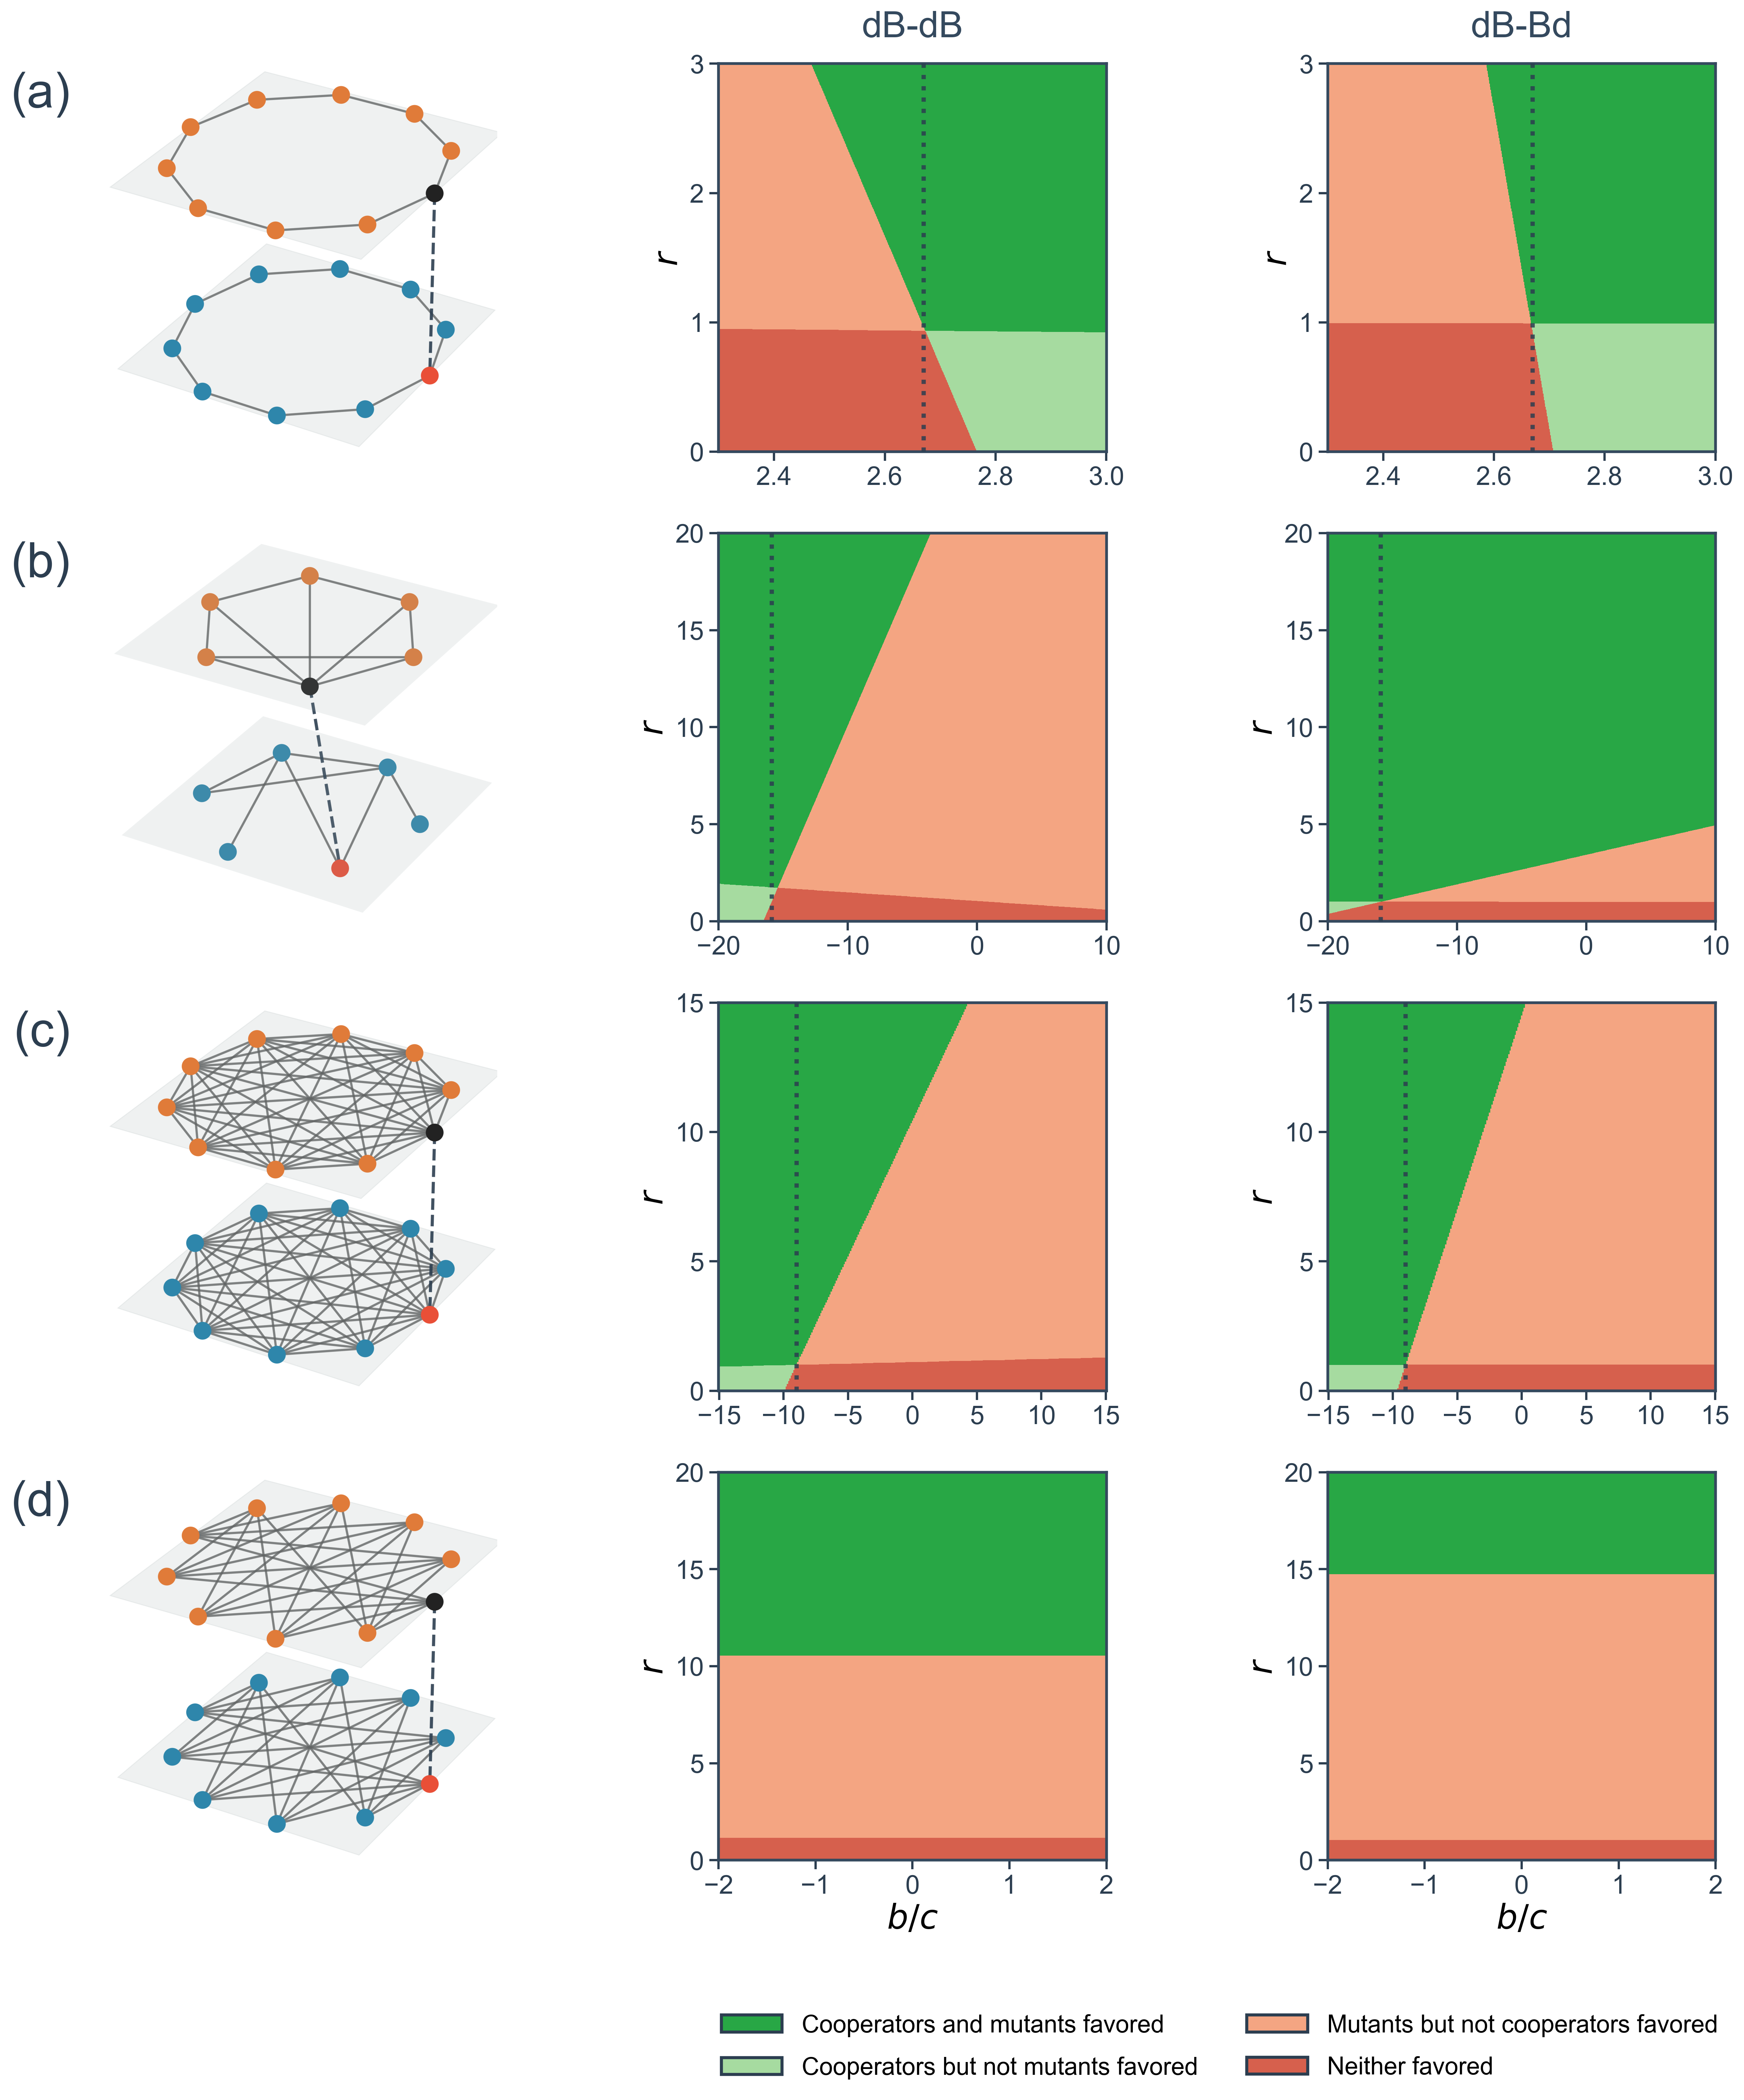

In [8]:
def create_composite_figure(
    output_basename: str = "final_plot_combined_4x3",
    save_png: bool = True,
    save_pdf: bool = True,
    dpi: int = 300
) -> plt.Figure:
    """
    Create the 4×3 composite figure with network diagrams and heatmaps.
    
    Parameters
    ----------
    output_basename : str
        Base filename for saved figures (without extension).
    save_png : bool, default=True
        Whether to save as PNG.
    save_pdf : bool, default=True
        Whether to save as PDF.
    dpi : int, default=300
        Resolution for output files.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated figure object.
    """
    # ----- Configure matplotlib for publication quality -----
    plt.rcParams.update({
        "figure.dpi": dpi,
        "xtick.labelsize": 17,
        "ytick.labelsize": 17,
        "axes.labelsize": 22,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
        "mathtext.fontset": "dejavusans",
        "pdf.fonttype": 42,  # TrueType fonts for PDF
        "ps.fonttype": 42,
    })
    
    # ----- Create figure and grid -----
    fig = plt.figure(figsize=(17, 20))
    fig.patch.set_facecolor('white')
    
    gs = fig.add_gridspec(
        4, 3,
        hspace=0.21,
        wspace=0.28,
        top=0.94,
        right=0.98,
        bottom=0.12,
        left=0.07
    )
    
    axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(4)]
    
    zoom = 1.3  # Zoom factor for network images
    
    # ----- Column 1: Network diagrams -----
    for row in range(4):
        if os.path.exists(NETWORK_IMAGES[row]):
            img = mpimg.imread(NETWORK_IMAGES[row])
            axes[row][0].imshow(center_crop(img, zoom))
            axes[row][0].axis('off')
        else:
            axes[row][0].text(
                0.5, 0.5,
                f"Missing:\n{NETWORK_IMAGES[row]}",
                ha='center', va='center',
                fontsize=12, color='red'
            )
            axes[row][0].axis('off')
    
    # ----- Columns 2-3: Heatmaps -----
    for row in range(4):
        cfg_dbdb = AXES_CONFIG[HEATMAP_FILES_DB_DB[row]]
        cfg_dbbd = AXES_CONFIG[HEATMAP_FILES_DB_BD[row]]
        
        if row == 3:
            # Row (d): Use extrapolated three-band visualization
            draw_three_band_extrapolated(
                axes[row][1],
                HEATMAP_FILES_DB_DB[row],
                cfg_dbdb["b"],
                cfg_dbdb["r"],
                xlabel=cfg_dbdb["xlabel"],
                custom_yticks=cfg_dbdb["custom_yticks"],
                custom_xticks=cfg_dbdb["custom_xticks"],
                target_rmax=cfg_dbdb["ymax_override"] or cfg_dbdb["r"][-1],
                xlim_override=cfg_dbdb["xlim_override"]
            )
            
            draw_three_band_extrapolated(
                axes[row][2],
                HEATMAP_FILES_DB_BD[row],
                cfg_dbbd["b"],
                cfg_dbbd["r"],
                xlabel=cfg_dbbd["xlabel"],
                custom_yticks=cfg_dbbd["custom_yticks"],
                custom_xticks=cfg_dbbd["custom_xticks"],
                target_rmax=cfg_dbbd["ymax_override"] or cfg_dbbd["r"][-1],
                xlim_override=cfg_dbbd["xlim_override"]
            )
        else:
            # Rows (a)-(c): Standard heatmaps
            draw_heatmap(
                axes[row][1],
                HEATMAP_FILES_DB_DB[row],
                cfg_dbdb["b"],
                cfg_dbdb["r"],
                vline_value=cfg_dbdb["vline"],
                xlabel=cfg_dbdb["xlabel"],
                force_four_xticks=(row in (1, 2)) and cfg_dbdb["custom_xticks"] is None,
                square=True,
                custom_yticks=cfg_dbdb["custom_yticks"],
                custom_xticks=cfg_dbdb["custom_xticks"],
                ymax_override=cfg_dbdb["ymax_override"],
                xlim_override=cfg_dbdb["xlim_override"]
            )
            
            draw_heatmap(
                axes[row][2],
                HEATMAP_FILES_DB_BD[row],
                cfg_dbbd["b"],
                cfg_dbbd["r"],
                vline_value=cfg_dbbd["vline"],
                xlabel=cfg_dbbd["xlabel"],
                force_four_xticks=(row in (1, 2)) and cfg_dbbd["custom_xticks"] is None,
                square=True,
                custom_yticks=cfg_dbbd["custom_yticks"],
                custom_xticks=cfg_dbbd["custom_xticks"],
                ymax_override=cfg_dbbd["ymax_override"],
                xlim_override=cfg_dbbd["xlim_override"]
            )
    
    # ----- Row labels (a)-(d) -----
    row_labels = ['(a)', '(b)', '(c)', '(d)']
    for row, label in enumerate(row_labels):
        axes[row][0].text(
            -0.10, 0.98, label,
            transform=axes[row][0].transAxes,
            fontsize=32,
            va='top', ha='right',
            color='#2C3E50',
            family='sans-serif'
        )
    
    # ----- Column headers -----
    col_labels = ['dB-dB', 'dB-Bd']
    for col, label in enumerate(col_labels):
        axes[0][col + 1].text(
            0.5, 1.05, label,
            transform=axes[0][col + 1].transAxes,
            fontsize=24,
            va='bottom', ha='center',
            color='#34495E'
        )
    
    # ----- Legend -----
    legend_handles = create_legend_handles()
    fig.legend(
        handles=legend_handles,
        loc='lower center',
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.69, 0.01),
        fontsize=16,
        columnspacing=2.0,
        handlelength=2.5,
        labelspacing=0.8
    )
    
    # ----- Save figures -----
    if save_png:
        plt.savefig(f"{output_basename}.png", dpi=dpi, bbox_inches='tight')
        print(f"Saved: {output_basename}.png")
    
    if save_pdf:
        plt.savefig(f"{output_basename}.pdf", dpi=dpi, bbox_inches='tight', format='pdf')
        print(f"Saved: {output_basename}.pdf")
    
    plt.show()
    
    return fig


# Uncomment to generate the figure:
fig = create_composite_figure()

---

<a id='single-row-figure'></a>
## 6. Single Row Figure

Generate a simplified figure showing only one network topology.
Useful for focused presentations or supplementary materials.

Saved: single_row_figure.png
Saved: single_row_figure.pdf


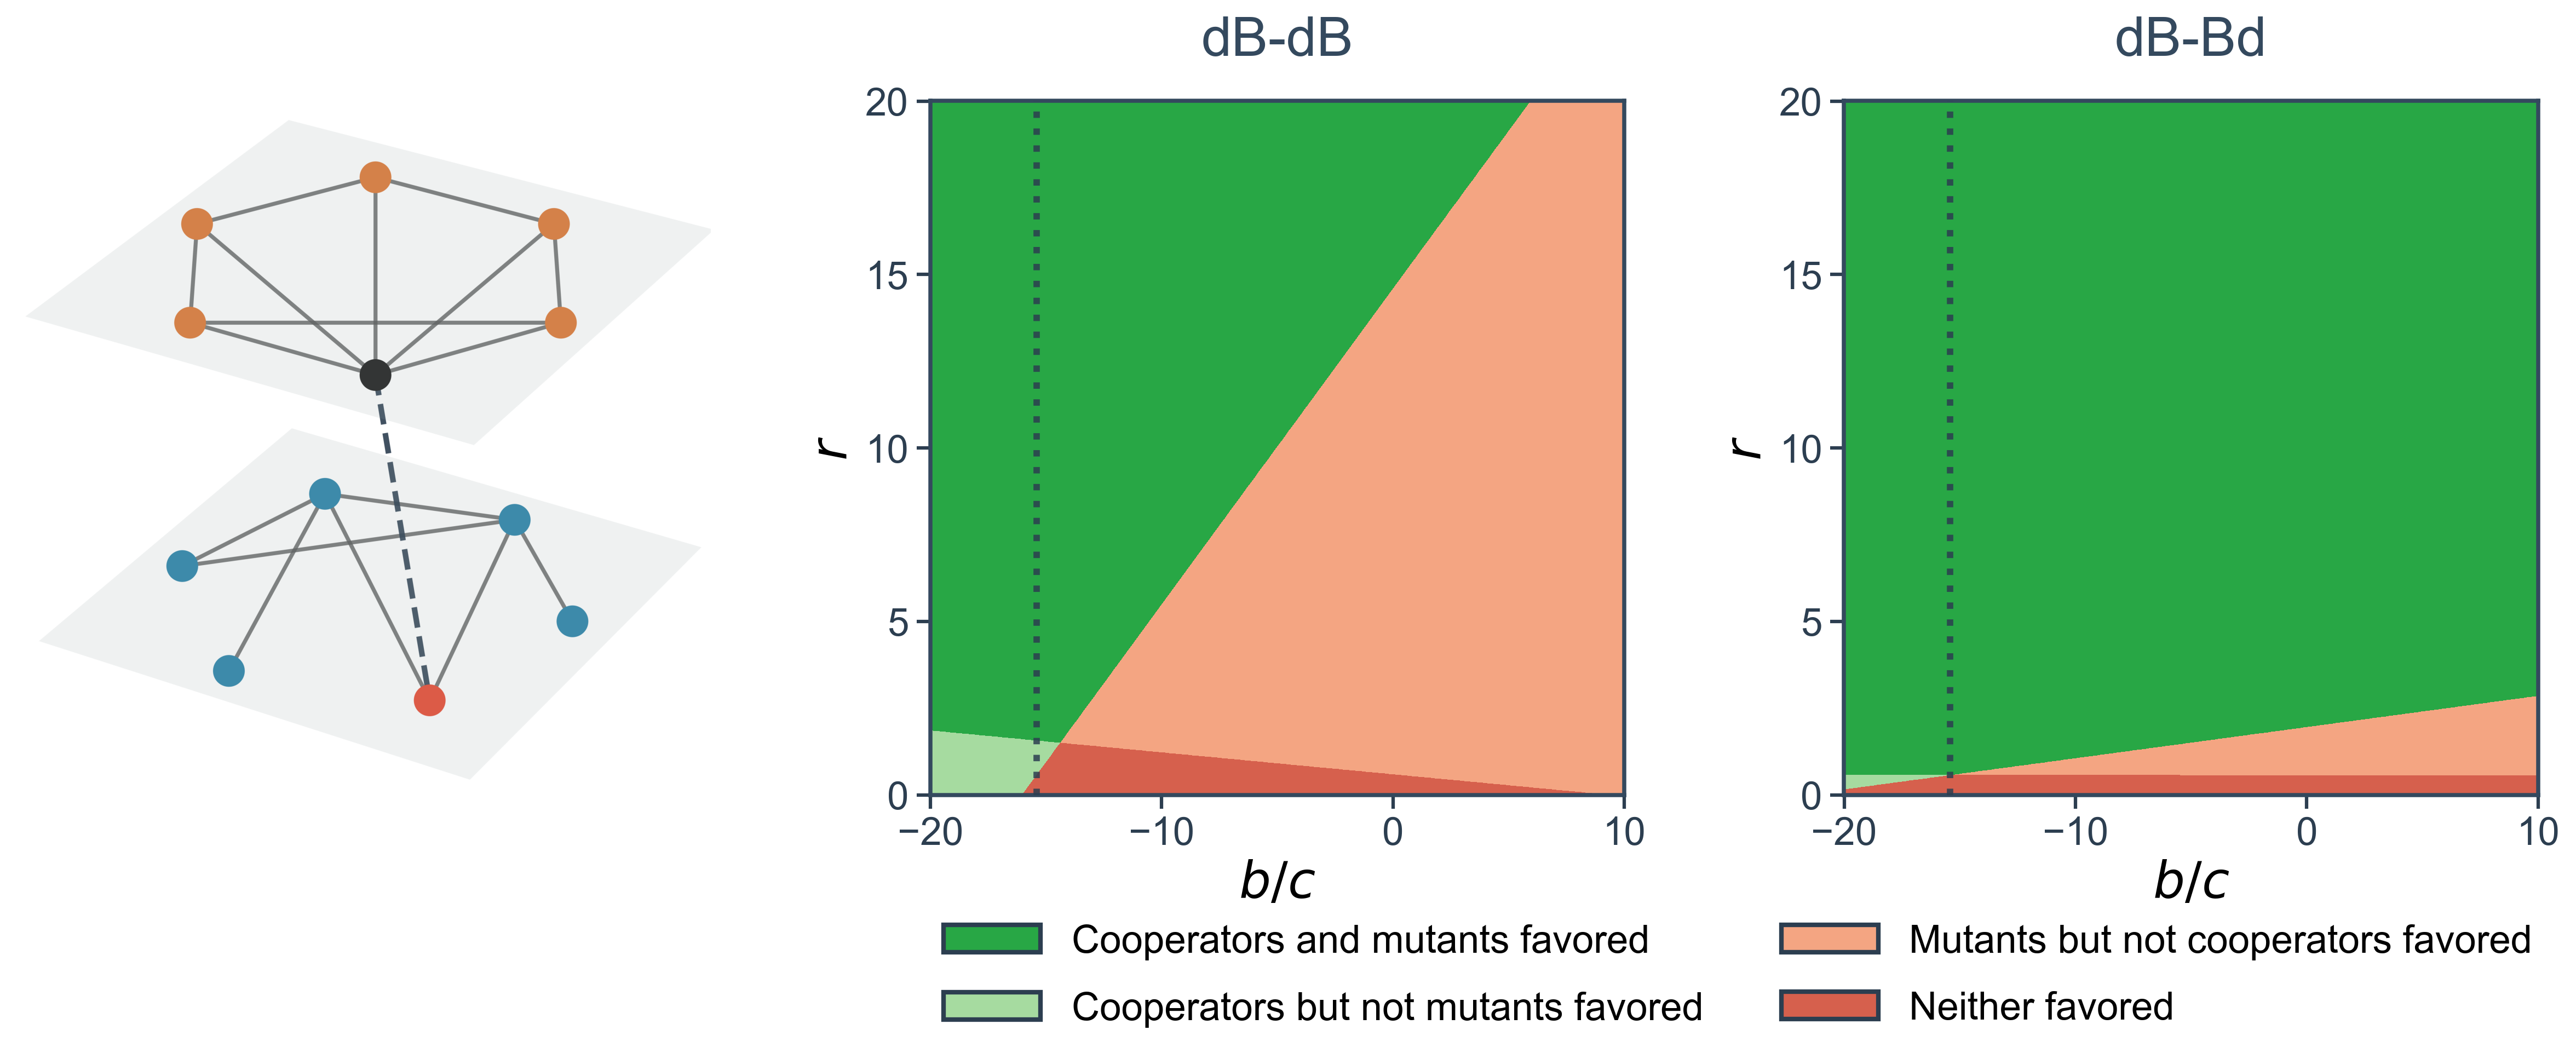

In [9]:
def create_single_row_figure(
    network_image: str = "multi_layer_network_hetero.png",
    heatmap_dbdb: str = "heatmap2_dB_dB_ff.npz",
    heatmap_dbbd: str = "heatmap2_dB_Bd_ff.npz",
    vline_value: float = -15.41,
    b_range: Tuple[float, float] = (-20.0, 10.0),
    r_range: Tuple[float, float] = (0.0, 20.0),
    output_basename: str = "single_row_figure",
    save_png: bool = True,
    save_pdf: bool = True,
    dpi: int = 300
) -> plt.Figure:
    """
    Create a single-row figure with one network and two heatmaps.
    
    Layout: [Network Image] [dB-dB Heatmap] [dB-Bd Heatmap]
    
    Parameters
    ----------
    network_image : str
        Path to the network diagram image.
    heatmap_dbdb : str
        Path to the dB-dB heatmap data file.
    heatmap_dbbd : str
        Path to the dB-Bd heatmap data file.
    vline_value : float
        X-coordinate for vertical reference line.
    b_range : tuple of float
        Range for b/c axis.
    r_range : tuple of float
        Range for r axis.
    output_basename : str
        Base filename for saved figures.
    save_png, save_pdf : bool
        Whether to save in each format.
    dpi : int
        Output resolution.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated figure.
    """
    # Configure matplotlib
    plt.rcParams.update({
        "figure.dpi": dpi,
        "xtick.labelsize": 17,
        "ytick.labelsize": 17,
        "axes.labelsize": 22,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
        "mathtext.fontset": "dejavusans",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })
    
    # Create figure
    fig = plt.figure(figsize=(17, 6.5))
    fig.patch.set_facecolor('white')
    
    gs = fig.add_gridspec(
        1, 3,
        hspace=0.3,
        wspace=0.28,
        top=0.88,
        right=0.98,
        bottom=0.23,
        left=0.07
    )
    
    axes = [fig.add_subplot(gs[0, j]) for j in range(3)]
    
    zoom = 1.3
    
    # Left: Network image
    if os.path.exists(network_image):
        img = mpimg.imread(network_image)
        axes[0].imshow(center_crop(img, zoom))
        axes[0].axis('off')
    else:
        axes[0].text(
            0.5, 0.5,
            f"Missing:\n{network_image}",
            ha='center', va='center',
            fontsize=12, color='red'
        )
        axes[0].axis('off')
    
    # Middle: dB-dB heatmap
    draw_heatmap_auto(
        axes[1],
        heatmap_dbdb,
        vline_value=vline_value,
        xlabel=r"$b/c$",
        b_range=b_range,
        r_range=r_range
    )
    
    # Right: dB-Bd heatmap
    draw_heatmap_auto(
        axes[2],
        heatmap_dbbd,
        vline_value=vline_value,
        xlabel=r"$b/c$",
        b_range=b_range,
        r_range=r_range
    )
    
    # Column headers
    for col, label in enumerate(['dB-dB', 'dB-Bd']):
        axes[col + 1].text(
            0.5, 1.05, label,
            transform=axes[col + 1].transAxes,
            fontsize=24,
            va='bottom', ha='center',
            color='#34495E'
        )
    
    # Legend
    legend_handles = create_legend_handles()
    fig.legend(
        handles=legend_handles,
        loc='lower center',
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.69, -0.02),
        fontsize=17,
        columnspacing=2.0,
        handlelength=2.5,
        labelspacing=0.8
    )
    
    # Save
    if save_png:
        plt.savefig(f"{output_basename}.png", dpi=dpi, bbox_inches='tight')
        print(f"Saved: {output_basename}.png")
    
    if save_pdf:
        plt.savefig(f"{output_basename}.pdf", dpi=dpi, bbox_inches='tight', format='pdf')
        print(f"Saved: {output_basename}.pdf")
    
    plt.show()
    
    return fig


# Uncomment to generate the figure:
fig = create_single_row_figure()

---

## Usage Examples

```python
# Generate the main 4×3 composite figure
fig = create_composite_figure(
    output_basename="publication_figure",
    save_png=True,
    save_pdf=True,
    dpi=300
)

# Generate a single-row figure for a specific network
fig = create_single_row_figure(
    network_image="ring_layer_network_3d.png",
    heatmap_dbdb="heatmap1_dB_dB.npz",
    heatmap_dbbd="heatmap1_dB_Bd.npz",
    vline_value=2.67,
    b_range=(2.3, 3.0),
    r_range=(0.0, 3.0),
    output_basename="ring_network_figure"
)
```

---

## Required Data Files

### Heatmap Data (.npz)
Each heatmap requires a NumPy .npz file with:
- `x_values`: 2D array of cooperator selection coefficients
- `y_values`: 2D array of mutant selection coefficients

### Network Images (.png)
Network diagram images for display in column 1.

---

